## Building a Transformer Model

Using this famous paper: https://arxiv.org/pdf/1706.03762.pdf

The objective is to create this architechture

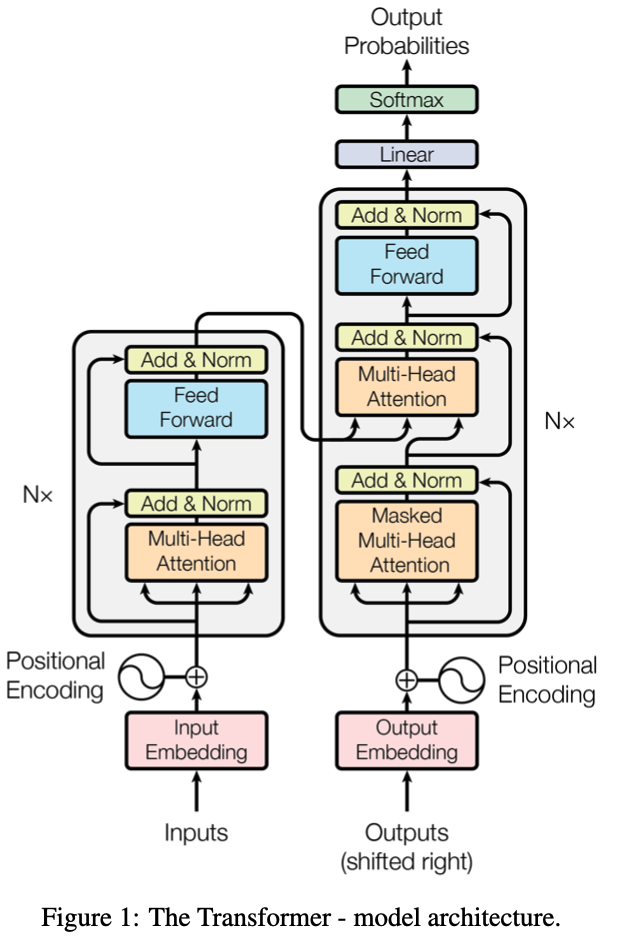

---

### Getting Data

Using the code from the data_analysis notebook.

In [50]:
import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(3791)

with open('the_lord_of_the_rings.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

batch_size = 4 # Number independant sequences of tokens we will process in parrallel
block_size = 8 # Maximum context length for predictions

def get_batch(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y 

print(decode(train_data[0:97].tolist()))


Three Rings for the Elven-kings under the sky,
Seven for the Dwarf-lords in their halls of stone,


The goal now that we have the data pulled in is to train a model to do text generation. The more techincal terminology for that is "next token prediction" meaning that the model will be able to look at what has come before and predict the character that will come next (More advanced models use words and peices of words but I am starting small)

<br>

---

### Embedding Table

The first peice of token prediction is to build a model that has the ability to record relationships between characters. We do this with a technology called the embedding table.

In [51]:
test_embedding = nn.Embedding(5, 5) # Random Embedding Table

for i in range(5):
    print(test_embedding(torch.tensor([i]))) # Retrieve Embedding

tensor([[-0.1155,  1.4004, -0.2636,  1.1846,  1.2524]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-1.4922, -0.8670,  0.4435, -0.1523, -0.1565]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 2.0149, -0.8710, -2.7495, -0.6273,  1.1433]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-2.1470, -0.3158, -0.1867,  0.9230, -0.7335]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.3809,  0.5600,  0.5015, -0.4943, -0.1860]],
       grad_fn=<EmbeddingBackward0>)


The embedding table is initialised with random weights that we are going to use to represent the probability of the character following the given token. 

You can call the values by "querying" the table for particular tensor. See above we ar calling with tensors [0], ... , [4] and getting the embedding tensor for each. This can also be done with a tensor of 2 dimensions to get multiple embedding tensors at once.

In [52]:
test_embedding(torch.tensor([[0], [1]]))

tensor([[[-0.1155,  1.4004, -0.2636,  1.1846,  1.2524]],

        [[-1.4922, -0.8670,  0.4435, -0.1523, -0.1565]]],
       grad_fn=<EmbeddingBackward0>)

See how with a 2x1 tensor we can call two embeddings. Thus we initialise our Bigram model with an embedding table.

In [53]:
class ExampleModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

model = ExampleModel(len(chars))
model.token_embedding_table(torch.tensor([0]))

tensor([[ 0.3442,  0.9577, -1.5105, -0.7749,  1.5252,  0.0909,  1.3469, -1.0264,
          0.6776, -0.5857,  0.3100,  0.0233, -0.5239,  0.6879, -0.3648,  0.4165,
         -0.3287, -0.3444,  0.9801, -0.6908,  0.1500, -0.8831,  0.0321,  0.4171,
          1.5222, -1.0674, -2.5141,  1.4262,  0.2582, -0.2657,  0.1911, -0.2096,
         -0.7396, -2.1908, -0.6412, -1.1399,  0.1989,  0.8807,  0.8749,  0.3764,
         -0.5525, -0.1188, -2.8033, -0.0061, -0.1929, -0.7781,  0.4275,  0.3869,
          0.0706,  0.7951, -0.9089,  0.0388,  0.7651,  1.5423, -0.4594, -0.0235,
         -0.9733,  0.7214, -1.3250,  2.0763,  0.0715,  0.3666, -0.6466, -0.2776,
         -1.4404, -0.2502, -0.5102,  1.1611, -0.1681,  0.9898,  1.9253,  0.6869,
          1.2430,  1.3106, -1.3647, -0.9620, -0.2909, -0.3432, -0.0999,  1.4572,
         -1.6297,  0.9408, -0.9184, -0.1979, -0.4507,  0.5716, -0.4538, -1.4719,
          0.8885,  0.6764]], grad_fn=<EmbeddingBackward0>)

This is the intialised embedding of the first char "\n". So the print out above is displaying the probabilities that the token will come after \n. So, for example the probability that \n will followin \n is -0.0876 in the 0th index of the tensor. Remember these are randomised so that isn't actually true but that is what the Embedding table is representing.

---

### Forward

All Neural Network models require a feed forward process to be defined. This will require that we make a prediction, and calulate the loss of that prediction vs the target.

In [54]:
xb, yb = get_batch(train_data)
print(xb[0])
print(decode(xb[0].tolist()))
print()
print(yb[0])
print(decode(yb[0].tolist()))

tensor([54, 57, 57, 66,  1, 73, 66, 53])
been una

tensor([57, 57, 66,  1, 73, 66, 53, 54])
een unab


As you can see from above, the first example in the batch has the input (idx) as the set of chars and then the target is shifted one along.

In [55]:
prediction = model.token_embedding_table(xb[0]) 
prediction.shape

torch.Size([8, 90])

So the model has used the existing weights to make a prediction. All it has done is call the embeddings of each on the 8 chars in the input. This returns 8 1x90 tensors giving the weights of the prediction that the next char will be each of the chars in the vocab list.

We can call for the whole batch together to parallelise the prediction.

In [56]:
multi_prediction = model.token_embedding_table(xb) 
multi_prediction.shape

torch.Size([4, 8, 90])

This gets us a (Number of Batches)x(Size of Batch)x(Vocab Size) tensor.

The naming convetion of this is logits which is a Batch x Time x Channel tensor.

Once, we have this prediction we need to calculated the loss between the logits and the targets using cross entropy. 

In [57]:
logits = model.token_embedding_table(xb) 
print(logits.shape)
print(yb.shape)

torch.Size([4, 8, 90])
torch.Size([4, 8])


But to do this we need to rearrange both tensors.

In [58]:
targets = yb
logits = model.token_embedding_table(xb) 
B, T, C = logits.shape

try:
    loss = F.cross_entropy(logits, targets)
except Exception as e:
    print("logits", logits.shape)
    print("targets", targets.shape)
    print(e)

print("-- Reshape --")
logits = logits.view(B*T, C)
targets = targets.view(B*T)

loss = F.cross_entropy(logits, targets)
print(logits.shape)
print(targets.shape)
print(loss)
print("loss:", loss.tolist())

logits torch.Size([4, 8, 90])
targets torch.Size([4, 8])
Expected target size [4, 90], got [4, 8]
-- Reshape --
torch.Size([32, 90])
torch.Size([32])
tensor(4.9346, grad_fn=<NllLossBackward0>)
loss: 4.934645175933838


Combing the batches into a single dimension 8x4 -> 32 allows the loss function to work on the whole channel. The for each of the 32 individual samples the loss is calculated and aggregated to a single value.

We can now add this as the forward method of the model.

In [59]:
class ExampleModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # Batch x Time x Channel, tensor prediction of what is next
        logits = self.token_embedding_table(idx) 

        if targets is None: # For predictions where there is no target i.e just generating.
            loss = None
        else:
            # Based on the PyTorch docs we need a B*C x T tensor to calcualate loss
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 

In [60]:
model = ExampleModel(len(chars))
inputs, targets = get_batch(train_data)

model(inputs, targets)

(tensor([[-0.3723,  0.7553, -0.0116,  ..., -0.4122, -0.1359, -0.3183],
         [-0.3925,  0.4913, -2.0963,  ...,  1.0126, -1.3088, -0.5255],
         [ 1.2102, -0.1006, -0.5687,  ..., -2.1167,  1.5608,  1.4984],
         ...,
         [ 0.3954, -1.8654, -0.9106,  ..., -1.1071, -0.4496,  0.5957],
         [-0.5680,  0.4464, -0.1636,  ..., -1.0656,  0.9717, -1.5425],
         [ 1.0697,  0.4621,  1.1798,  ..., -0.8339, -1.6184, -0.7691]],
        grad_fn=<ViewBackward0>),
 tensor(4.7117, grad_fn=<NllLossBackward0>))


---

### Generation

The next thing to add to the model is a method that askes it to generate text based on the current embedding weights. This will be very similar to the forward method but instead of calculating the loss we turn the logits into an output tensor.

Choosing a random token:

In [61]:
token_id = 26
decode([token_id])

'B'

So, can now just get the logits from the forward method.

In [62]:
idx = torch.tensor([[token_id]])
logits, loss = model(idx)
logits = logits[:, -1, :] 
logits


tensor([[ 1.1858e+00, -4.9327e-01, -1.9447e+00, -4.4081e-01,  2.6501e-03,
          5.3936e-01,  2.1330e-01, -7.1541e-01,  6.8131e-02, -7.1106e-01,
         -1.5422e+00,  1.6065e+00,  2.3858e+00, -5.6496e-01, -1.7900e+00,
          1.0732e+00,  1.5358e+00,  6.3908e-01, -4.0596e-01, -9.1557e-02,
          1.0003e+00, -3.2269e-01, -4.4188e-01, -3.2526e-01, -3.3579e-01,
          3.4698e-01, -1.4513e+00,  2.5231e-01, -3.1592e-01,  3.8024e-02,
         -1.2849e-01,  8.4887e-01,  1.3745e+00,  6.9393e-01, -1.0462e+00,
         -7.2398e-01,  1.3280e+00,  2.8721e-01, -5.1100e-01,  1.8616e-01,
         -5.2194e-01, -9.6673e-01,  9.4727e-01,  1.1304e+00, -1.0383e+00,
         -7.2330e-01, -5.5404e-01, -1.1394e+00,  3.7563e-01,  4.5904e-01,
          1.0331e+00, -2.4764e+00,  2.2267e+00,  1.4216e+00, -8.0848e-01,
         -1.3861e+00,  1.1532e+00, -2.0237e+00,  7.7194e-01,  5.5535e-01,
         -2.4234e-01, -8.2424e-01, -9.8410e-01, -8.4057e-01, -2.9957e-01,
         -3.8765e-01, -1.1245e+00,  8.

Now we can softmax to get the probabilty of each character.

In [63]:
probs = F.softmax(logits, dim=-1) 
probs

tensor([[0.0207, 0.0039, 0.0009, 0.0041, 0.0063, 0.0108, 0.0078, 0.0031, 0.0068,
         0.0031, 0.0014, 0.0315, 0.0687, 0.0036, 0.0011, 0.0185, 0.0294, 0.0120,
         0.0042, 0.0058, 0.0172, 0.0046, 0.0041, 0.0046, 0.0045, 0.0089, 0.0015,
         0.0081, 0.0046, 0.0066, 0.0056, 0.0148, 0.0250, 0.0127, 0.0022, 0.0031,
         0.0239, 0.0084, 0.0038, 0.0076, 0.0038, 0.0024, 0.0163, 0.0196, 0.0022,
         0.0031, 0.0036, 0.0020, 0.0092, 0.0100, 0.0178, 0.0005, 0.0586, 0.0262,
         0.0028, 0.0016, 0.0200, 0.0008, 0.0137, 0.0110, 0.0050, 0.0028, 0.0024,
         0.0027, 0.0047, 0.0043, 0.0021, 0.0151, 0.0283, 0.0142, 0.0047, 0.0071,
         0.0014, 0.0147, 0.0144, 0.0063, 0.0044, 0.0013, 0.0041, 0.0586, 0.0095,
         0.0069, 0.0057, 0.0046, 0.0088, 0.0033, 0.1081, 0.0037, 0.0039, 0.0067]],
       grad_fn=<SoftmaxBackward0>)

We can the sample 1 tensor based on the multinomial distribtion across the probabilities.

In [64]:
torch.multinomial(probs, num_samples=1)

tensor([[12]])

It will help to demonstrate how this works graphically by running multinomial 10000 times and plotting the results.

In [65]:
results_dict = {i: 0 for i in range(0, 90)}
for _ in range(10000):
    result = torch.multinomial(probs, num_samples=1)
    results_dict[result[0].tolist()[0]] += 1

In [66]:
prob_dict = {}
for i, prob in enumerate(probs[0].tolist()):
    prob_dict[i] = prob

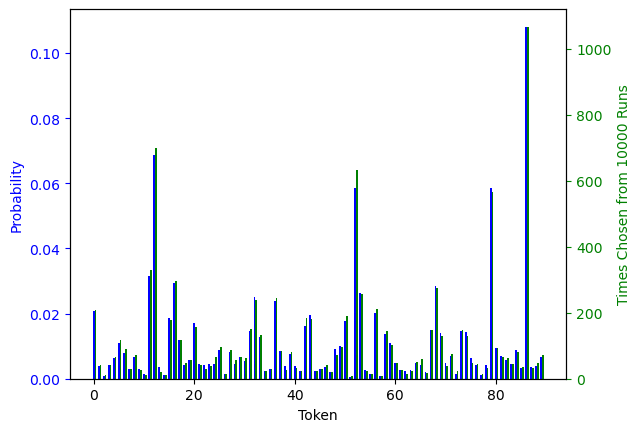

In [83]:
import matplotlib.pyplot as plt
import numpy as np

keys = list(prob_dict.keys())
values1 = list(prob_dict.values())
values2 = list(results_dict.values())

bar_width = 0.35

r1 = np.arange(len(keys))
r2 = [x + bar_width for x in r1]

fig, ax1 = plt.subplots()

ax1.bar(r1, values1, width=bar_width, label='Dataset 1', color='b')
ax1.set_xlabel('Token')
ax1.set_ylabel('Probability', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(r2, values2, width=bar_width, label='Dataset 2', color='g')
ax2.set_ylabel('Times Chosen from 10000 Runs', color='g')
ax2.tick_params('y', colors='g')

plt.show()


See how the probability and rate of selection relate to one another.

Finally we can piece this all together.

In [68]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) 

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
m = BigramLanguageModel(len(chars)) 

print("Batch:", decode(xb[0].tolist()))
gen = m.generate(xb, 5)
print("Generation:", decode(gen[0].tolist()))


Batch: been una
Generation: been una9pA=5


So, it works. We just need to train it.

---

### Training Loop

The training loop is very simple at this stage. The only additional componant we need is an optimizer which controls the progressive small steps towards the optimum (lowest, in this case) loss.  

In [69]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

With that we can step through the simple loop:

For a given number of steps:
- Get a batch of the training data
- Predict the next token
- Calculate the loss
- Take a step in a direction towards the lower loss. 

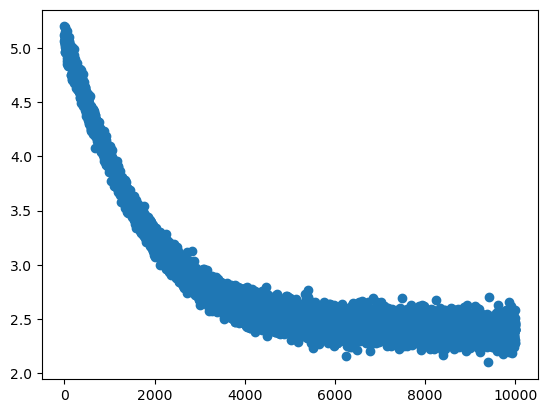

In [70]:
batch_size = 32
number_of_steps = 10000
losses = []

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)          # Getting batch of training data.
    logits, loss = m(xb, yb)                # Predict next token and calculate loss.

    optimizer.zero_grad(set_to_none=True)   
    loss.backward()                         # Back propagate the loss.
    optimizer.step()                        # Adjust the optimizer.

    losses.append(loss.item())              # Storing losses to plot.

plt.scatter(range(0, 10000), losses)

This does pretty well and should reflect in the improved generation.

In [71]:
print("Batch:", decode(xb[0].tolist()))
gen = m.generate(xb, 15)
print("Generation:", decode(gen[0].tolist()))

Batch: ' grandm
Generation: ' grandm bor: y balodin


It's not Tolkien but it does seem to understand the english language better now.

In [72]:
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 8100


So, far we have accomplished the following 2 peices with a single Neural Network module in between:

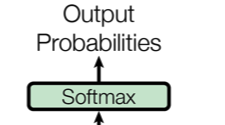

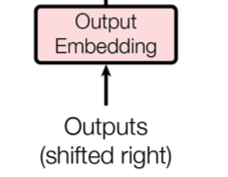

Our module has a simple embedding of 90x90 = 8100 parameters. To improve the performance we need to add attenetion

---

### Token and Positional Embedding Tables

To be able to build up a more complex Neural net we need to understand the token and positional embedding tables

In [84]:
n_embd = 16
batch_size = 4
block_size = 8 
token_embedding_table = nn.Embedding(vocab_size, n_embd)
position_embedding_table = nn.Embedding(block_size, n_embd)

Similar to our embedding table earlier the idea is to record a relationship of the tokens and the positions. But this time it is more abstracted as we are not just comparing each of the tokens to the indiviual token before but instead we record the relationship with of the token with a selected abstract "number of embeddings" and likewise we record the position by embedding the location of the token in the the block with the number of embeddings.

In [85]:
xb, yb = get_batch(train_data)
B, T = xb.shape
print("B:", B)
print("T:", T)
print()
token_embedding = token_embedding_table(xb)
position_embedding = position_embedding_table(torch.arange(T))
print(token_embedding.shape)
print()
print(position_embedding.shape)

B: 4
T: 8

torch.Size([4, 8, 16])

torch.Size([8, 16])


So, as shown above a batch of 4 blocks of 8 tokens is input into the token embedding table and for each token in each batch there are 16 embeddings given. Likewise for each block there are 16 positional, embeddings returned. Remember the number of embeddings is chose by us and the more embeddings means the more params in our model.

In [86]:
x = token_embedding + position_embedding
x.shape

torch.Size([4, 8, 16])

Now adding these together combines a posistional embedding with a token embedding thus giving us our logits for the xb batch representing the relationship of the token to it's position and the embeddings.

In [94]:
linear_example = nn.Linear(n_embd, vocab_size)
linear_example(x).shape

torch.Size([4, 8, 90])

To reshape the tensor into a input to token mapping tensor we then need to add the linear part of the transformer:

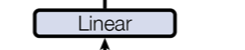

Thus, changing this embedding into a BlockxBatch -> Token mapping tensor i.e. (BxTxvocab_size)


In [115]:
class ModelWithPosition(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
m = ModelWithPosition()
logits, loss = m(xb)

print("Input:", xb.shape)
print("Logits:", logits.shape)
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Input: torch.Size([4, 8])
Logits: torch.Size([4, 8, 90])
Number of Parameters: 3098


The parametes here are made up by the dimension of the token embeddings table plus the position embeddings table. Then, a linear transformation gets applied to convert the tensor to the correct dimensions.

In [103]:
n_embd * vocab_size + \
n_embd * block_size + \
(n_embd + 1) * vocab_size

3098

The 1 comes from the bias which is the additional vector of vocab_sizex1 added in the linear transformation.

In [107]:
class ModelWithoutBias(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

    
m = ModelWithoutBias()
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 3008


---

### Single Head of Self-attention

In our current model the token and position in the block are being encoded. This is a good start but the model is not training based on the data around the token. A given token would need to have some way of learning based on the values of the tokens around them not just the token itself and the position in the block. This is why we introduce self-attention.

Self-attention involves the initialisation of Linear embeddings that contain the key (the content of the position) and the query (what the position is looking for). To get the probabilities we dot product the key and query

In [129]:
head_size = 2
key = nn.Linear(n_embd, head_size, bias=False)
query = nn.Linear(n_embd, head_size, bias=False)

k = key(x) # B, T, head_size
q = query(x) # B, T, head_size

wei = q @ k.transpose(-2,-1) # Transpose the last 2 dimensions. So (B, T, 16) @ (B, 16, T) ---> (B, T, T)

print("k shape:", k.shape)
print("q shape:", q.shape)
print("wei shape:", wei.shape)

k shape: torch.Size([4, 8, 2])
q shape: torch.Size([4, 8, 2])
wei shape: torch.Size([4, 8, 8])


Now for every batch B we have a T squared matrix giving the affinities bewteen the keys and the queries.

Then we can create a matrix with ones in a triangular pattern. This will seperate out each array of tokens. So with an input:

        Hello World!

We will look at:

        H
        He
        Hel
        Hell
        Hello
        Hello 
        Hello W

Etc

In [132]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

Applying this to our example we can see for the first batch the triangulated matrix of affinites 

In [135]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei[0]

tensor([[-0.7639,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.7197, -0.4224,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.4082,  0.0468, -0.2418,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.5605,  0.4591, -1.6518, -0.7197,    -inf,    -inf,    -inf,    -inf],
        [-1.5293,  0.1786, -0.9169, -0.7385, -1.1699,    -inf,    -inf,    -inf],
        [ 2.1539,  0.4065, -0.9082,  0.2894,  0.0676, -0.7060,    -inf,    -inf],
        [-1.8311,  0.7474, -2.8813, -1.4929, -2.6820, -0.9613, -3.3143,    -inf],
        [ 1.3382, -0.7068,  2.6423,  1.2742,  2.3456,  0.9318,  2.6591, -1.1981]],
       grad_fn=<SelectBackward0>)

Then as before we can softmax and get the output.

In [140]:
wei = F.softmax(wei, dim=1)
out = wei @ x
out.shape # B, T, C

torch.Size([4, 8, 16])

We now have a data dependant representation of each token and position where each token embedding will hold a query and a key. That query and key dot product together so that embeddings with high affinities to other embeddings create higher probabilities.

The only difference when applying this properly is that we have third linear transoformation that containes the values of x.

In [154]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

n_embd = 16
m = Head(head_size=16)
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 768


In [155]:
16 * 16 * 3 # Parameters.

768

Okay so we have our encoded text data and we can see where the same characters get the same token id. 1 is a space for example. 

In [51]:
torch.manual_seed(3791) # Set manual seed for repeatability. There Rings for the Elven-kings... and so on.



m = BigramLanguageModel(len(chars)) 
idx_init = torch.zeros((1, 1), dtype=torch.long)
decode(m.generate(idx_init, max_new_tokens=100)[0].tolist())

'\nQ. XQûb)d9IFF;?Iú_M,KCnáJ9Cíkou cdwâ=O4GE4N 9-wlg7M;:3bjaëu`Y8Ná/)7fYy8\n,ëiWMKë=WëeD upjuUú/qSäc)FTk'

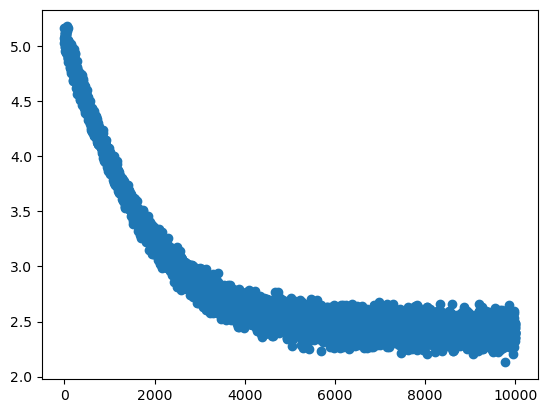

In [33]:
batch_size = 32
number_of_steps = 10000
losses = []
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

from matplotlib import pyplot as plt

plt.scatter(range(0, 10000), losses)

In [34]:
def generate_text(model, text_length):
    idx_init = torch.zeros((1, 1), dtype=torch.long)
    return decode(model.generate(idx_init, max_new_tokens=text_length)[0].tolist())

print(generate_text(m, 1000))


 eng w se sthet by Fome  wimood rlelbs ay,  s fe.ät iOf aret!ldis Thandsere Fou!ë' é'I anghe s wastunth RFOritheeresepremy: pe hinuent heme hop Th awea`Ridobowhiroot Brs t wngashayoumanut-m FYy wouPif wid frmin heigrd p  ArerKGaroondorCo fi03G; foroto spearen t owitce h ved an Oful Hing if pt oryoof rme wawinean le arlat. theng theark   ind  t. t mm.  n  isaine ?'
 uchut t  Galilin kEntoan a t  irideausited ptrotherd agstheeshere  issat t t  e  ngaá/Ourowe ho t xtit sarouthad?', toond, vee I is; blden'ok wagrd leevemit skeer ors ckery;_, rsabos doutherad wind len, to s oul sande, akiellyshedope se hesude imof f tr wed d whad anthp co ws, m,' akelifoprso jQDebu Br a  eetordofe  ade!
 nd de r hacl ocou yondlle  ss d  _Thatocror  wr t BOver tllvem.'s Ljalf oued. meileyouadans athenghef Fre ashig, t wenass ay iere t. n, wang, f ts me of obad t hedon hin _l ala2Ainod ow ooropee wit Then I touthand s. thas co lld tsh ly ous bEEppofes, tad I R. ty  Cong witur  Ocleche, t s; It Elfu ghe t Tho